In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import pandas
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.python.keras.models import Model
from keras.utils import plot_model

import seaborn as sns
import os
import tempfile
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
oversample = SMOTE()
import joblib

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df = pandas.read_csv('../colo_data_mar22_d032222.csv')

In [4]:
df = df[[

    'age',
    'sex',
    
    'race7',
    'educat',
    'marital',
    'occupat',

    'cig_stat',
    'cig_years',
    'cigpd_f',
    'cigar',
    'pipe',

    'fh_cancer',

    'bmi_curr',

    'asppd',
    'ibuppd',
    
    'arthrit_f',
    'bronchit_f',
    'colon_comorbidity',
    'diabetes_f',
    'divertic_f',
    'emphys_f',
    'gallblad_f',
    'hearta_f',
    'hyperten_f',
    'liver_comorbidity',
    'osteopor_f',
    'polyps_f',
    'stroke_f',

    'colo_cancer'

]]

In [5]:
# filling null values
for column in df:
    if (column == 'bmi_curr'): df[column] = df[column].fillna(df[column].mean())
    else: df[column] = df[column].fillna(df[column].mode()[0])

df.isnull().sum()

age                  0
sex                  0
race7                0
educat               0
marital              0
occupat              0
cig_stat             0
cig_years            0
cigpd_f              0
cigar                0
pipe                 0
fh_cancer            0
bmi_curr             0
asppd                0
ibuppd               0
arthrit_f            0
bronchit_f           0
colon_comorbidity    0
diabetes_f           0
divertic_f           0
emphys_f             0
gallblad_f           0
hearta_f             0
hyperten_f           0
liver_comorbidity    0
osteopor_f           0
polyps_f             0
stroke_f             0
colo_cancer          0
dtype: int64

In [6]:
y = df['colo_cancer']
X = df.drop('colo_cancer', axis = 1)

In [7]:
neg, pos = numpy.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

X, y = oversample.fit_resample(X, y)

neg, pos = numpy.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 154887
    Positive: 2359 (1.52% of total)

Examples:
    Total: 305056
    Positive: 152528 (50.00% of total)



In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state=42)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size = 0.25, random_state=42)

train_features = numpy.array(train_features)
test_features = numpy.array(test_features)
val_features = numpy.array(val_features)

train_labels = numpy.array(train_labels)
test_labels = numpy.array(test_labels)
val_labels = numpy.array(val_labels)

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (183033, 28)
Validation features shape: (61011, 28)
Test features shape: (61012, 28)
Training labels shape: (183033,)
Validation labels shape: (61011,)
Test labels shape: (61012,)


In [ ]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

def make_model():
  
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(train_features.shape[-1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 16

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='auto',
)

In [ ]:
model = make_model()
model.summary()

In [ ]:
model = make_model()
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
plot_metrics(baseline_history)

In [9]:
BATCH_SIZE = 16
model = keras.models.load_model('Neuralmodel.h5')

In [10]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

3814/3814 [==============================] - 3s 846us/step


In [11]:
def plot_cm(labels, predictions, p=0.5):
  cm = metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('(Good) No Cancer Detected (True Negatives): ', cm[0][0])
  print('(Okay) No Cancer Thought to Have Cancer (False Positives): ', cm[0][1])
  print('(Bad) Cancer Thought to Have No Cancer (False Negatives): ', cm[1][0])
  print('(Good) Cancer Detected (True Positives): ', cm[1][1])
  print('Total Cancer Cases: ', numpy.sum(cm[1]))

loss :  0.28848063945770264
tp :  24869.0
fp :  1677.0
tn :  28813.0
fn :  5653.0
accuracy :  0.8798596858978271
precision :  0.9368266463279724
recall :  0.814789354801178
auc :  0.945645272731781
prc :  0.9564622044563293

(Good) No Cancer Detected (True Negatives):  28813
(Okay) No Cancer Thought to Have Cancer (False Positives):  1677
(Bad) Cancer Thought to Have No Cancer (False Negatives):  5653
(Good) Cancer Detected (True Positives):  24869
Total Cancer Cases:  30522


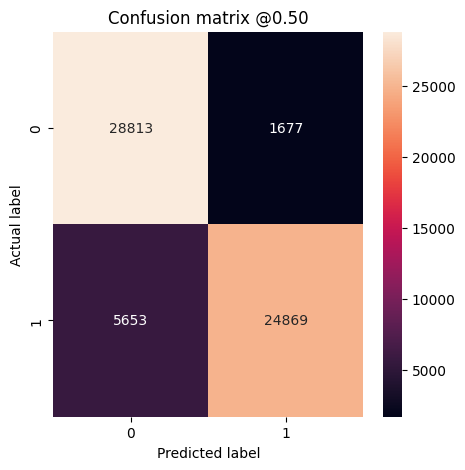

In [12]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [13]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

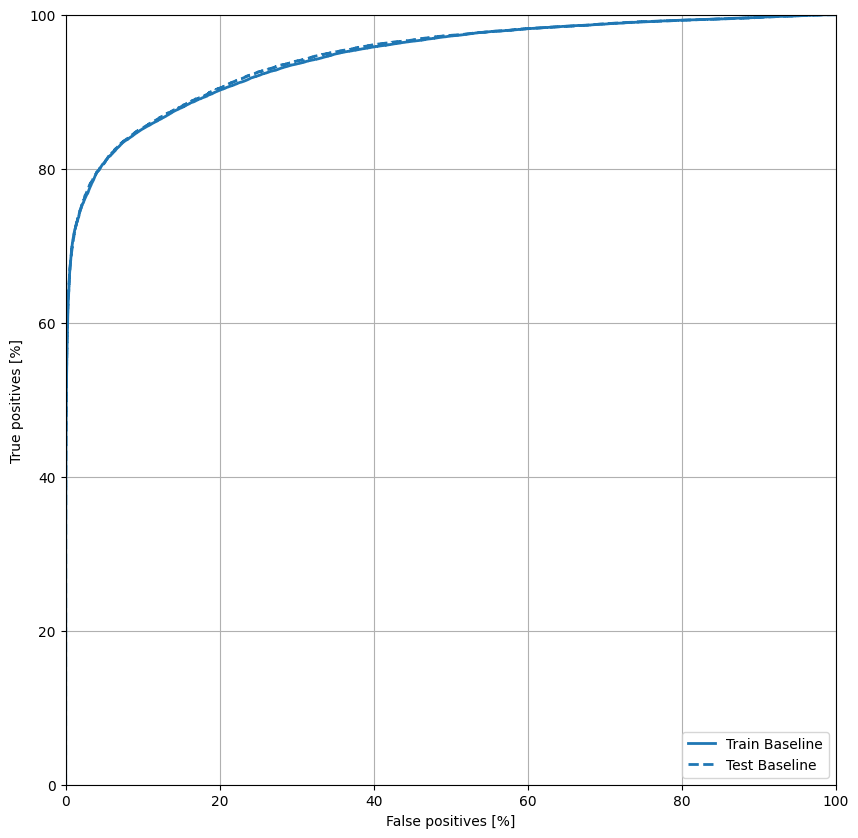

In [14]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [15]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

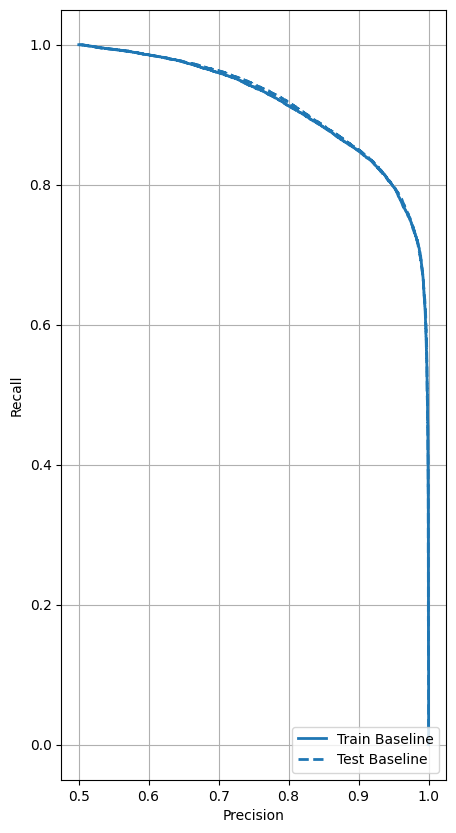

In [16]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
model.save('Neuralmodel.h5')
joblib.dump(scaler, 'Neuralscaler.pkl');